In [2]:
# Step 1: Import required libraries
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Step 2: Face Detection Function
Detect and crop faces from images using Haar cascades.

In [3]:
def detect_face(image_path, cascade_path='haarcascade_frontalface_default.xml', target_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cascade_path)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, target_size)
    return face

## Step 3: Prepare Data for CNN Training
Load images, detect faces, preprocess, and split into training and test sets.

In [4]:
data_dir = '../football_dataset'  # Adjust path if needed
classes = sorted(os.listdir(data_dir))
X = []
y = []

for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        face = detect_face(img_path)
        if face is not None:
            X.append(face)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Normalize images
X = X / 255.0

# One-hot encode labels
y_cat = to_categorical(y, num_classes=len(classes))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print(f'Total samples: {len(X)}')
print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Total samples: 530
Training samples: 424
Test samples: 106


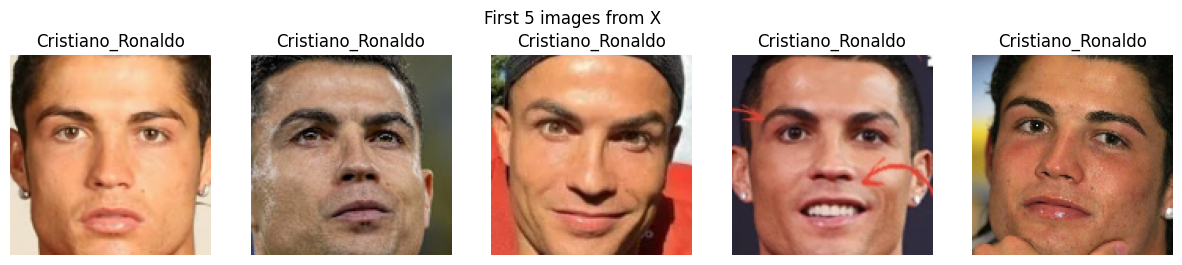

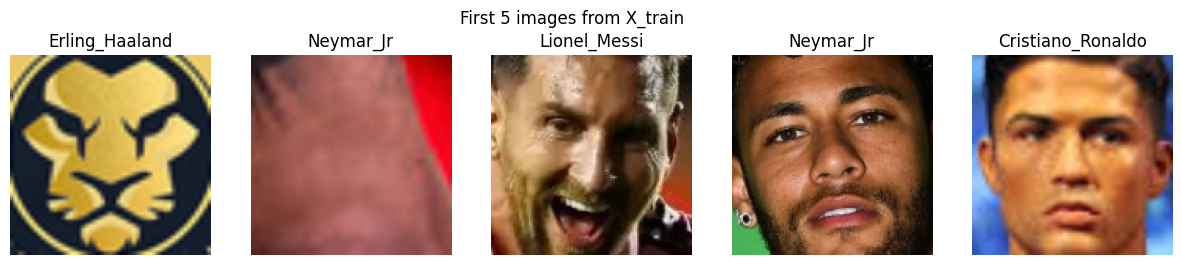

In [5]:
# Display some sample images from X and X_train
import matplotlib.pyplot as plt

def show_samples(images, labels, classes, n=5, title='Samples'):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(cv2.cvtColor((images[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show first 5 images from X
show_samples(X, y_cat, classes, n=5, title='First 5 images from X')

# Show first 5 images from X_train
show_samples(X_train, y_train, classes, n=5, title='First 5 images from X_train')

## Step 4: Build the CNN Model
Define and compile a simple CNN for footballer face classification.

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\USER\Desktop\NS3 model\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Train the CNN Model
Train the model and visualize accuracy and loss.

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2358 - loss: 1.6418 - val_accuracy: 0.3208 - val_loss: 1.6043
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2358 - loss: 1.6418 - val_accuracy: 0.3208 - val_loss: 1.6043
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.2665 - loss: 1.5949 - val_accuracy: 0.4057 - val_loss: 1.5736
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.2665 - loss: 1.5949 - val_accuracy: 0.4057 - val_loss: 1.5736
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3585 - loss: 1.5056 - val_accuracy: 0.3679 - val_loss: 1.5283
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3585 - loss: 1.5056 - val_accuracy: 0.3679 - val_loss: 1.5283
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3892 - loss: 1.4702 - val_accuracy: 0.4151 - val_loss: 1.4244
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3892 - loss: 1.4702 - val_accuracy: 0.4151 - v

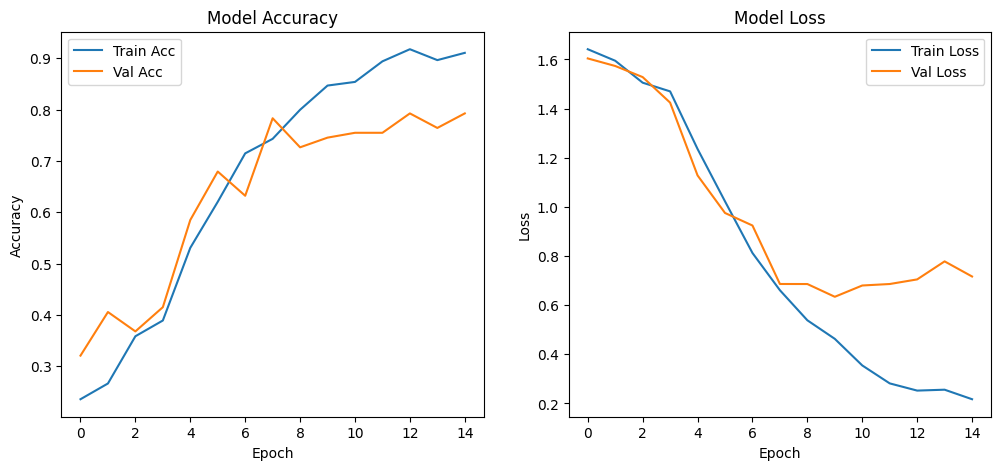

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
    )

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 6: Evaluate the Model
Check test accuracy and show a classification report.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Test Accuracy: 0.79
                   precision    recall  f1-score   support

Cristiano_Ronaldo       0.96      0.75      0.84        32
   Erling_Haaland       0.85      0.89      0.87        19
    Kylian_Mbappe       0.68      0.87      0.76        15
     Lionel_Messi       0.79      0.69      0.73        16
        Neymar_Jr       0.68      0.79      0.73        24

         accuracy                           0.79       106
        macro avg       0.79      0.80      0.79       106
     weighted avg       0.81      0.79      0.79       106

Test Accuracy: 0.79
                   precision    recall  f1-score   support

Cristiano_Ronaldo       0.96      0.75      0.84        32
   Erling_Haaland       0.85      0.89      0.87        19
    Kylian_Mbappe       0.68      0.87      0.76        15
     Lionel_Messi       0.79      0.69      0.73        16
        Neymar_Jr       0.68      0.79      0.73      

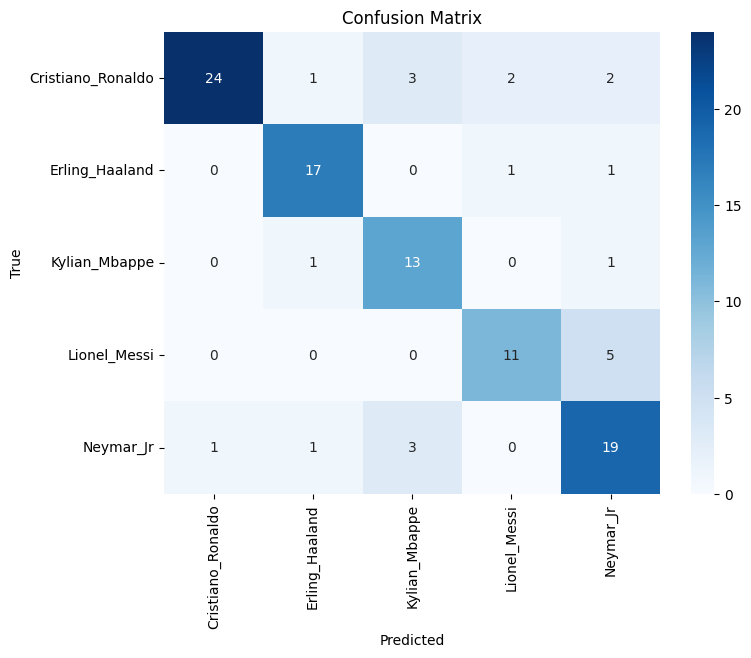

In [8]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Test accuracy
test_acc = accuracy_score(y_true_classes, y_pred_classes)
print(f'Test Accuracy: {test_acc:.2f}')

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Save the trained model to disk
model.save('footballer_face_classifier.h5')
print('Model saved as footballer_face_classifier.h5')

Model saved as footballer_face_classifier.h5
